# 1. Подготовка данных

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.utils import shuffle
import numpy as np
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('Churn.csv')

In [4]:
data = data.drop('Unnamed: 0', axis=1)

Изучение датасета

In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
data.sample()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9442,9443,15606552,Akabueze,741,France,Male,37,9.0,105261.76,2,1,1,149503.54,0


In [17]:
data.tail()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Spain,Gender_Female,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3
9995,771,39,5.0,0.00,1,0,96270.64,0,1,0,0,0,1,0
9996,516,35,10.0,57369.61,1,1,101699.77,0,1,0,0,1,0,0
9997,709,36,7.0,0.00,0,1,42085.58,1,1,0,1,1,0,0
9998,772,42,3.0,75075.31,1,0,92888.52,1,0,0,0,0,1,0
9999,792,28,1.0,130142.79,1,0,38190.78,0,1,0,1,1,0,0


In [18]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Наблюдается дисбаланс классов. Ушедших клиентов почти в 4 раза меньше.

Удаляю столбцы `RowNumber`, `CustomerId`, `Surname` с индивидуальными признаками

In [5]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Около 10% пропусков в `Tenure`. Заменяю пропуски модой.

In [6]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].mode()[0])

In [7]:
data['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

Меняю тип столбца `NumOfProducts` на `object` для дальнейшего прямого кодирования.

In [8]:
data['NumOfProducts'] = data['NumOfProducts'].astype('object')

Прямое кодирование категориальных признаков

In [9]:
data = pd.get_dummies(data)

Удаление избыточных стобцов `Gender_Male`, `Geography_Germany` и `NumOfProducts_4`

In [10]:
data = data.drop(['Gender_Male', 'Geography_Germany', 'NumOfProducts_4'], axis=1)

Создание переменных для признаков и целевого признака

In [11]:
X = data.drop(columns=['Exited'])
y = data['Exited']

Так как у нас нет скрытой тестовой выборки, то с помощью `train_test_split` разбиваю данные на две части - обучающую и тестовую в соотношении 70:30 соответственно. Сохраняем дисбаланс классов.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. Исследование задачи

#### Обучение моделей без учёта дисбаланса

Функция для расчета `F1-меры` и `ROC-AUC` и построения графиков. Предсказание на тестовой выборке после обучения модели на тренировочной выборке.

In [13]:
def f1_roc_auc_score(models):
    models_list = []
    f1 = []
    auc = []
    for model in models:
        model.fit(X_train, y_train)
        test_predictions = model.predict(X_test)
        f1_test_score = round(f1_score(y_test, test_predictions), 2)
        probabilities_test = model.predict_proba(X_test)
        probabilities_one_test = probabilities_test[:, 1]
        auc_roc = round(roc_auc_score(y_test, probabilities_one_test), 2)
        models_list.append(type(model).__name__)
        auc.append(auc_roc)
        f1.append(f1_test_score)
    fig = go.Figure(
    data=[go.Bar(x=models_list, y=f1)],
    layout=dict(title=dict(text="F1-мера")))
    fig.update_layout(autosize=False,width=700,height=350)
    fig.show('png')
    fig = go.Figure(
    data=[go.Bar(x=models_list, y=auc)],
    layout=dict(title=dict(text="ROC-AUC")))
    fig.update_layout(autosize=False,width=700,height=350)
    fig.show('png')

In [14]:
models = [LogisticRegression(random_state=42), 
          DecisionTreeClassifier(random_state=42), 
          RandomForestClassifier(random_state=42)]

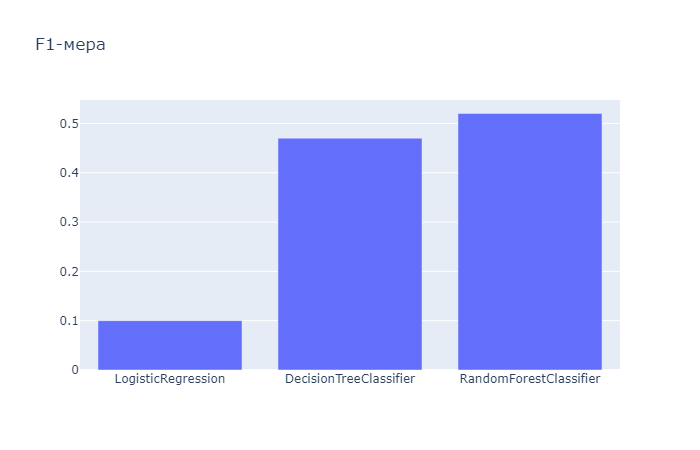

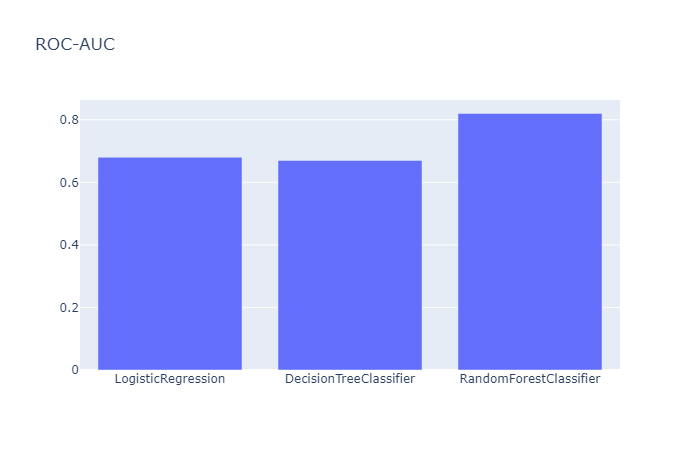

In [15]:
f1_roc_auc_score(models)

#### Вывод:
   - На тестовой выборке без учета дисбаланса лучшее значение `F1-меры` 0.55 удалось достичь, используя `RandomForestClassifier`. У `DecisionTreeClassifier` результат немного меньше - 0.48. Самый худший результат 0.1 показала `LogisticRegression`. 
   - Не наблюдается зависимости значений `F1-меры` и `ROC-AUC`.

# 3. Борьба с дисбалансом

### Исследование моделей с учетом дисбаланса

Балансирую вес классов, используя в моделях аргумент `class_weight='balanced'`

#### Логистическая регрессия

Значимым гиперпараметром является коэффициент регуляризации `C`. Для поиска оптимального значения использую `GridSearchCV` с кросс-валидацией на пяти подвыборках.

In [16]:
parameters = {'C': (0.01, 0.1, 1, 10, 100, 1000, 10000)}

In [17]:
grid_lr = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'),
                       parameters, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)
params = grid_lr.best_params_
lr_balanced = LogisticRegression(**params, random_state=42, class_weight='balanced')
lr_balanced.fit(X_train, y_train)
grid_lr.best_params_

{'C': 100}

#### Решающее дерево и случайный лес

Для `DecisionTreeClassifier` и `RandomForestClassifier` поиск будет осуществляться по гиперпараметрам `max_depth`, `min_samples_split` и `min_samples_leaf`. Создаю переменную `tree_params` c различными вариантами значений указанных гиперпараметров.

In [18]:
tree_params = {'max_depth': list(range(4, 25)),
               'min_samples_split': list(range(2, 17, 2)),
               'min_samples_leaf': list(range(1, 15, 2))}

Выбор гиперпараметров для решающего дерева. Для поиска оптимального значения использую `GridSearchCV` с кросс-валидацией на пяти подвыборках.

In [19]:
grid_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                         tree_params, cv=5, n_jobs=-1, scoring='f1') 
grid_dtc.fit(X_train, y_train)
params = grid_dtc.best_params_
dtc_balanced = DecisionTreeClassifier(**params, random_state = 42, class_weight='balanced')
dtc_balanced.fit(X_train, y_train)
grid_dtc.best_params_

{'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 2}

Выбор гиперпараметров для случайного леса. Для поиска оптимального значения использую `GridSearchCV` с кросс-валидацией на пяти подвыборках.

In [20]:
grid_rfc = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), 
                         tree_params, cv=5, n_jobs=-1, scoring='f1') 
grid_rfc.fit(X_train, y_train)
params = grid_rfc.best_params_
rfc_balanced = RandomForestClassifier(**params, random_state = 42, class_weight='balanced')
rfc_balanced.fit(X_train, y_train)
grid_rfc.best_params_

{'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 12}

In [21]:
models_balanced = [lr_balanced, dtc_balanced, rfc_balanced]

Функция для расчета `F1-меры` и `ROC-AUC` и построения графиков. Предсказания на тестовой выборке для обученных моделей.

In [34]:
def f1_roc_auc_score_trained(models):
    models_list = []
    f1 = []
    auc = []
    for model in models:
        test_predictions = model.predict(X_test)
        f1_test_score = round(f1_score(y_test, test_predictions), 2)
        probabilities_test = model.predict_proba(X_test)
        probabilities_one_test = probabilities_test[:, 1]
        auc_roc = round(roc_auc_score(y_test, probabilities_one_test), 2)
        models_list.append(type(model).__name__)
        auc.append(auc_roc)
        f1.append(f1_test_score)
    fig = go.Figure(
    data=[go.Bar(x=models_list, y=f1)],
    layout=dict(title=dict(text="F1-мера")))
    fig.update_layout(autosize=False,width=700,height=350)
    fig.show('png')
    fig = go.Figure(
    data=[go.Bar(x=models_list, y=auc)],
    layout=dict(title=dict(text="ROC-AUC")))
    fig.update_layout(autosize=False,width=700,height=350)
    fig.show('png')

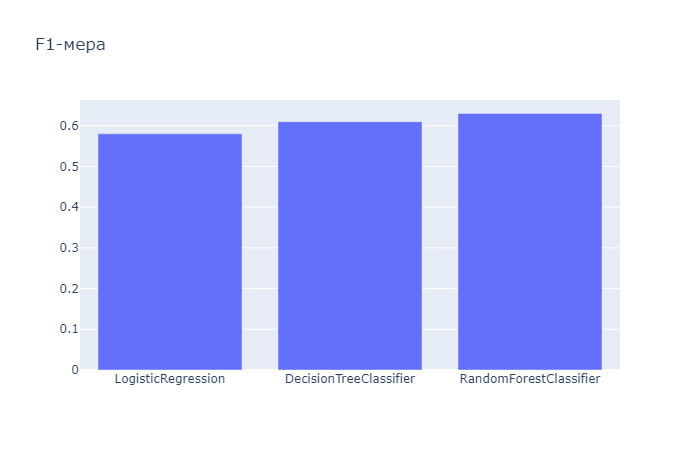

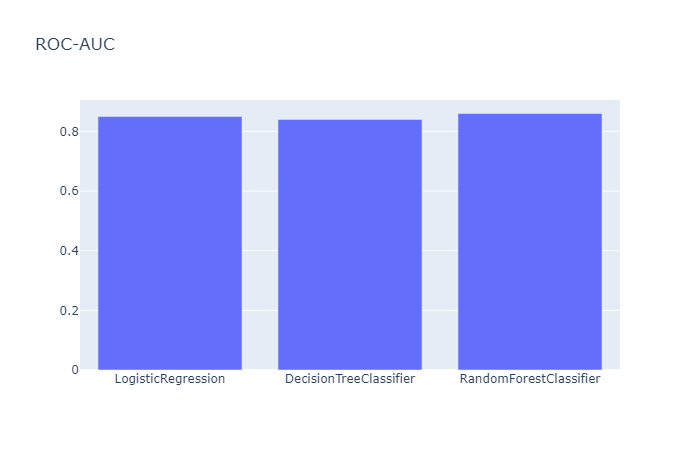

In [35]:
f1_roc_auc_score_trained(models_balanced)

Использую ещё один способ борьбы с дисбалансом классов - уменьшение выборки

Создаю функцию `downsample`, которая делит обучающую выборку на отрицательные и положительные объекты, случайным образом отбрасывает часть из отрицательных объектов и, перемешав данные, создаёт новую обучающую выборку


In [26]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

Для исправления дисбаланса нужно оставить 25% отрицательных объектов

In [27]:
X_downsampled, y_downsampled = downsample(X_train, y_train, 0.25)

In [28]:
(X_downsampled.shape), (y_downsampled.shape)

((2820, 13), (2820,))

#### Обучение моделей после уменьшения выборки

Выбор гиперпараметров для логистической регрессии. Для поиска оптимального значения использую `GridSearchCV` с кросс-валидацией на пяти подвыборках.

In [29]:
grid_lr = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'),
                       parameters, cv=5, n_jobs=-1, scoring='f1')
grid_lr.fit(X_downsampled, y_downsampled)
params = grid_lr.best_params_
lr_downsample = LogisticRegression(**params, random_state=42, class_weight='balanced')
lr_downsample.fit(X_downsampled, y_downsampled)
grid_lr.best_params_

{'C': 1}

Выбор гиперпараметров для решающего дерева. Для поиска оптимального значения использую `GridSearchCV` с кросс-валидацией на пяти подвыборках.

In [30]:
grid_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                         tree_params, cv=5, n_jobs=-1, scoring='f1') 
grid_dtc.fit(X_downsampled, y_downsampled)
params = grid_dtc.best_params_
dtc_downsample = DecisionTreeClassifier(**params, random_state = 42, class_weight='balanced')
dtc_downsample.fit(X_downsampled, y_downsampled)
grid_dtc.best_params_

{'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 16}

Выбор гиперпараметров для случайного леса. Для поиска оптимального значения использую `GridSearchCV` с кросс-валидацией на пяти подвыборках.

In [31]:
grid_rfc = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), 
                         tree_params, cv=5, n_jobs=-1, scoring='f1') 
grid_rfc.fit(X_downsampled, y_downsampled)
params = grid_rfc.best_params_
rfc_downsample = RandomForestClassifier(**params, random_state = 42, class_weight='balanced')
rfc_downsample.fit(X_downsampled, y_downsampled)
grid_rfc.best_params_

{'max_depth': 16, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [32]:
models_downsample = [lr_downsample, dtc_downsample, rfc_downsample]

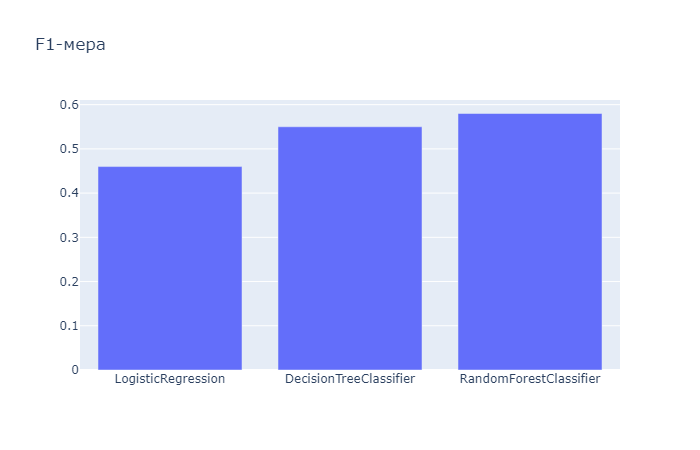

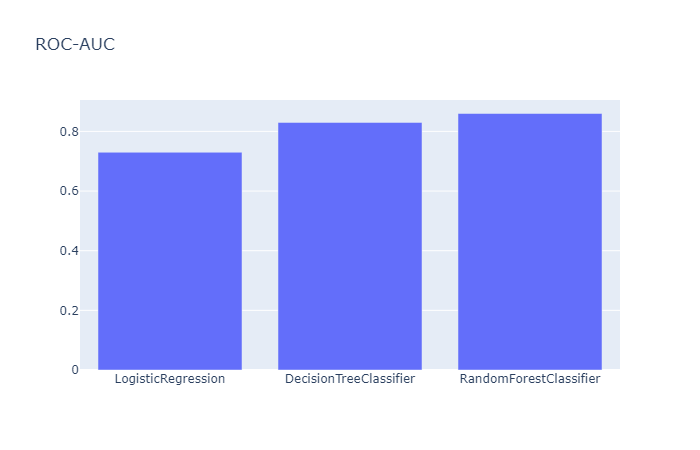

In [36]:
f1_roc_auc_score_trained(models_downsample)

### Вывод
   - На тестовой выборке лучшее значение `F1-меры` у `RandomForestClassifier`: 0.62 у модели, обученной с балансировкой весов, 0.56 - на уменьшенной выборке. Результаты других моделей в пределах 0.46-0.52.
   - `ROC-AUC` слабочувствительна к дисбалансу классов, поэтому нет значительных изменений.